In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import shutil
from IPython.display import FileLink
import skimage.transform
from PIL import Image
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
daily_data = 1

In [3]:
original_start = '1998-01-01'

if daily_data == 1:
    original_end = '2019-12-30'
else:
    original_end = '2019-12-01'
    
chosen_start = original_start
chosen_end = original_end

# Convert chosen start and end dates to datetime
chosen_start = pd.to_datetime(chosen_start)
chosen_end = pd.to_datetime(chosen_end)

# Convert original start and end dates to datetime
original_start = pd.to_datetime(original_start)
original_end = pd.to_datetime(original_end)

In [4]:
# Specify the directory where the .nc4 files are located
if daily_data == 1:
    directory = "/kaggle/input/trmm-daily-2/trmm_daily"
else:
    directory = "/kaggle/input/trmm-monthly/monthly"

In [5]:
check_max = 0

if check_max == 1:
    # Create an empty list to store the maximum precipitation values
    max_precipitations = []

    # Loop through the .nc4 files in the directory to find the maximum precipitation
    counter = 0
    for filename in os.listdir(directory):
        if filename.endswith(".nc4"):
            # Extract the date from the filename
            if daily_data == 1:
                file_date = filename.split(".")[1]
            else:
                file_date = filename.split(".")[1].split("_")[0]

            # Convert the file date to a datetime object
            file_date = pd.to_datetime(file_date)

            # Check if the file date is within the chosen range
            if chosen_start <= file_date <= chosen_end:
                # Construct the full file path
                file_path = os.path.join(directory, filename)

                # Load the dataset using xarray with the netCDF4 engine
                dataset = xr.open_dataset(file_path, engine='netcdf4')

                # Calculate the maximum precipitation value
                max_precipitation = dataset['precipitation'].max().item()
                max_precipitations.append(max_precipitation)

                # Delete the dataset to free up memory
                del dataset

            if counter % 100 == 0:
                print(str(counter) + str(len(os.listdir(directory))) + " files checked")
            counter += 1

    # Find the overall maximum precipitation value
    overall_max_precipitation = max(max_precipitations)
    print(overall_max_precipitation)

In [6]:
overall_max_precipitation = 1035.929931640625

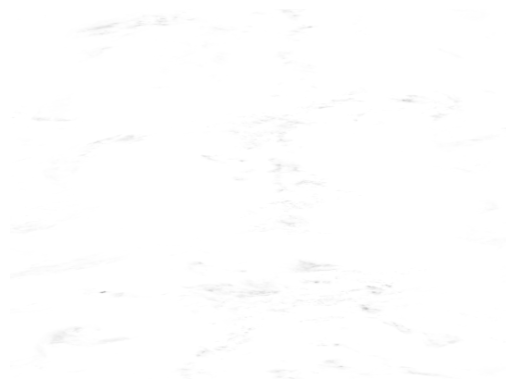

Image saved: /kaggle/working/rainfall_images/2001-06-06.png (Size: 1440x400)
100 out of 8034 files turned to images
200 out of 8034 files turned to images
300 out of 8034 files turned to images
400 out of 8034 files turned to images
500 out of 8034 files turned to images
600 out of 8034 files turned to images
700 out of 8034 files turned to images
800 out of 8034 files turned to images
900 out of 8034 files turned to images
1000 out of 8034 files turned to images
1100 out of 8034 files turned to images
1200 out of 8034 files turned to images
1300 out of 8034 files turned to images
1400 out of 8034 files turned to images
1500 out of 8034 files turned to images
1600 out of 8034 files turned to images
1700 out of 8034 files turned to images
1800 out of 8034 files turned to images
1900 out of 8034 files turned to images
2000 out of 8034 files turned to images
2100 out of 8034 files turned to images
2200 out of 8034 files turned to images
2300 out of 8034 files turned to images
2400 out of 

In [7]:
# Create the output directory
output_directory = "/kaggle/working/rainfall_images"
os.makedirs(output_directory, exist_ok=True)

# Get the list of already existing image files
existing_files = set(os.listdir(output_directory))

# Initialize the previous image precipitation array and missing pixel counter
prev_precipitation = None
missing_pixels = 0

# Define the desired output resolution
output_width = 1440
output_height = 400

# Define the desired range for pixel values (0 to 255)
desired_min_value = 0
desired_max_value = 255

# Loop through the .nc4 files again to create scaled images
counter = 0
for filename in os.listdir(directory):
    if filename.endswith(".nc4"):
        # Extract the date from the filename
        if daily_data == 1:
            file_date = filename.split(".")[1]
        else:
            file_date = filename.split(".")[1].split("_")[0]

        # Convert the file date to a datetime object
        file_date = pd.to_datetime(file_date)

        # Check if the file date is within the chosen range
        if chosen_start <= file_date <= chosen_end:
            # Generate the image file name based on the date
            image_date = file_date.strftime("%Y-%m-%d")
            image_file = f"{image_date}.png"

            # Check if the image file already exists in the output directory
            if image_file in existing_files:
                # Skip the file loading and image creation if it already exists
                counter += 1
                continue

            # Construct the full file path
            file_path = os.path.join(directory, filename)

            # Load the dataset using xarray with the netCDF4 engine
            with xr.open_dataset(file_path, engine='netcdf4') as dataset:
                # Retrieve the precipitation values
                precipitation = dataset['precipitation'].values

                # Fill missing values with the previous image's precipitation values
                if prev_precipitation is not None:
                    missing_indices = np.isnan(precipitation)
                    if np.any(missing_indices):
                        #print(f"Missing values found in file: {filename}")
                        missing_pixels += np.sum(missing_indices)
                        precipitation[missing_indices] = prev_precipitation[missing_indices]

                # Update the previous image precipitation array
                prev_precipitation = precipitation.copy()

                # Scale the precipitation values between 0 and 1
                scaled_precipitation = precipitation / overall_max_precipitation

                # Scale the precipitation values to the desired range (0 to 255)
                scaled_precipitation = scaled_precipitation * (desired_max_value - desired_min_value) + desired_min_value

                # Resize the image to the desired resolution
                image = skimage.transform.resize(scaled_precipitation, (output_height, output_width), anti_aliasing=True)

                # Save the image to the output directory without specifying cmap
                image_path = os.path.join(output_directory, image_file)
                plt.imsave(image_path, image, cmap='binary', vmin=desired_min_value, vmax=desired_max_value)

                # Display only the first image
                if counter == 0:
                    plt.imshow(image, cmap='binary', aspect='auto', vmin=desired_min_value, vmax=desired_max_value)
                    plt.axis('off')
                    plt.show()

                    # Print the size of the image
                    image_size = (output_width, output_height)
                    print(f"Image saved: {image_path} (Size: {image_size[0]}x{image_size[1]})")

            counter += 1

            # Print the counter every 100 files
            if counter % 100 == 0:
                print(str(counter) + " out of " + str(len(os.listdir(directory))) + " files turned to images")

# Print the final count of missing pixels
print(f"Total missing pixels: {missing_pixels}")

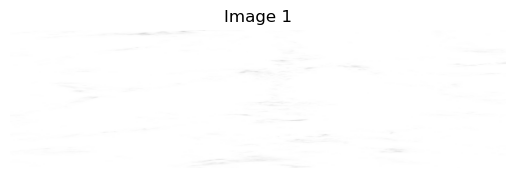

Minimum value in Image 1: 0.7882
Maximum value in Image 1: 1.0000


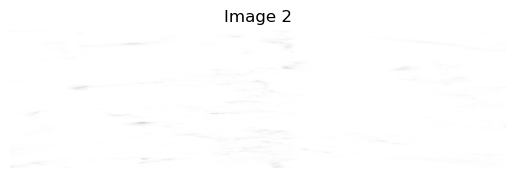

Minimum value in Image 2: 0.7255
Maximum value in Image 2: 1.0000


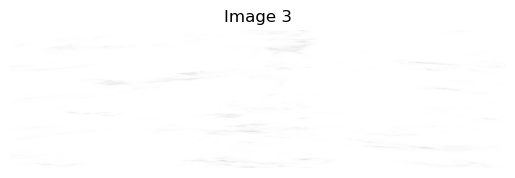

Minimum value in Image 3: 0.8471
Maximum value in Image 3: 1.0000


In [8]:
# Directory where the images are saved
image_directory = "/kaggle/working/rainfall_images"

# Get a list of all image files in the directory
image_files = os.listdir(image_directory)

# Display the first 3 images
for i in range(3):
    # Load the image as a grayscale image
    image_path = os.path.join(image_directory, image_files[i])
    image = plt.imread(image_path)

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()

    # Calculate and print the minimum and maximum values in the image
    min_value = np.amin(image)
    max_value = np.amax(image)
    print(f"Minimum value in Image {i+1}: {min_value:.4f}")
    print(f"Maximum value in Image {i+1}: {max_value:.4f}")

In [9]:
# Function to get the first image file in a directory
def get_first_image(directory):
    image_files = sorted(os.listdir(directory))
    first_image_file = image_files[0]
    first_image_path = os.path.join(directory, first_image_file)
    return first_image_path

In [10]:
# Get the path of the first image
first_image_path = get_first_image("/kaggle/working/rainfall_images")

# Open the image using PIL and convert to grayscale
first_image = Image.open(first_image_path).convert("L")

# Convert the image to a NumPy array
image_array = np.array(first_image)

# Print the shape of the image array
print("Image shape:", image_array.shape)

# Find the maximum value in the whole image
max_pixel_value = np.max(image_array)
print("Maximum pixel value in the image:", max_pixel_value)

# Find the minimum value in the whole image
min_pixel_value = np.min(image_array)
print("Minimum pixel value in the image:", min_pixel_value)

Image shape: (400, 1440)
Maximum pixel value in the image: 255
Minimum pixel value in the image: 158


In [11]:
# Create the output directory
output_directory = "/kaggle/working/rainfall_images"
os.makedirs(output_directory, exist_ok=True)
   
# Create a ZIP file of the output directory
shutil.make_archive("/kaggle/working/rainfall_images", 'zip', output_directory)

'/kaggle/working/rainfall_images.zip'

In [5]:
# Read the data from the Excel file
df_flood = pd.read_excel('/kaggle/input/flood-archive/FloodArchive.xlsx', index_col=0)

# Rename the 'lon' and 'lat' columns to 'lon' and lat' respectively
df_flood = df_flood.rename(columns={'long': 'longitude', 'lat': 'latitude'})

# Define the TRMM grid resolution
grid_resolution = 0.25  # Change this value based on the desired TRMM grid resolution

# Round lon and lat to the nearest values ending in .875, .625, .375, or .125
df_flood['lon'] = (df_flood['longitude'] // grid_resolution) * grid_resolution + 0.125
df_flood['lat'] = (df_flood['latitude'] // grid_resolution) * grid_resolution + 0.125

# Filter the data using the best bandwidth
chosen_band_width = 50
lower_bound = -chosen_band_width
upper_bound = chosen_band_width
df_flood = df_flood[(df_flood['lat'] >= lower_bound) & (df_flood['lat'] <= upper_bound)]

if daily_data == 1:
    transformed_flood_data = []
    
    # Convert Began and Ended columns to datetime type
    df_flood['Began'] = pd.to_datetime(df_flood['Began'])
    df_flood['Ended'] = pd.to_datetime(df_flood['Ended'])
    
    # Iterate over each row in the df_flood DataFrame
    for _, row in df_flood.iterrows():
        # Get the start and end dates for the flood
        start_date = row['Began'].date()
        end_date = row['Ended'].date()

        # Generate a list of dates between the start and end dates
        date_range = pd.date_range(start=start_date, end=end_date, freq='D')

        # Repeat the row for each date in the range
        for date in date_range:
            transformed_flood_data.append({
                'lon': row['lon'],
                'lat': row['lat'],
                'datetime': date,
                'flood': 1
            })
            
    # Create the transformed DataFrame
    filtered_flood = pd.DataFrame(transformed_flood_data)
    
    # Filter the dataframe based on the chosen period
    start_date = pd.to_datetime(chosen_start).date()
    end_date = pd.to_datetime(chosen_end).date()
    filtered_flood = filtered_flood[(filtered_flood['datetime'].dt.date >= start_date) & (filtered_flood['datetime'].dt.date <= end_date)]

else:
    # Convert Began and Ended columns to datetime type
    df_flood['Began'] = pd.to_datetime(df_flood['Began'])
    df_flood['Ended'] = pd.to_datetime(df_flood['Ended'])
    
    # Create a datetime column containing the first day of the month in which the flood started
    df_flood['datetime'] = df_flood['Began'].dt.to_period('M').dt.to_timestamp()

    # Filter the dataframe based on the chosen period
    start_date = pd.to_datetime(chosen_start).replace(day=1).date()
    end_date = pd.to_datetime(chosen_end).replace(day=1).date()
    filtered_flood = df_flood[(df_flood['datetime'].dt.date >= start_date) & (df_flood['datetime'].dt.date <= end_date)]
    
    # Add a flood column filled with ones
    filtered_flood['flood'] = 1

# Keep only the lon, lat, datetime, and flood columns
filtered_flood = filtered_flood[['lon', 'lat', 'datetime', 'flood']]

filtered_flood = filtered_flood.sort_values(by=['lon', 'lat', 'datetime'])

# Display the resulting filtered dataframe
display(filtered_flood.head(10))

,lon,lat,datetime,flood
36132,-173.375,-13.875,2009-09-29,1
19770,-170.625,-14.375,2003-05-18,1
19771,-170.625,-14.375,2003-05-19,1
40940,-159.625,22.125,2012-03-04,1
40941,-159.625,22.125,2012-03-05,1
40942,-159.625,22.125,2012-03-06,1
40943,-159.625,22.125,2012-03-07,1
27032,-159.375,22.125,2006-03-14,1
27033,-159.375,22.125,2006-03-15,1
27034,-159.375,22.125,2006-03-16,1


In [6]:
# Create a list of dates from chosen_start to chosen_end
all_dates = pd.date_range(start=chosen_start, end=chosen_end, freq='D').date

# Print the list of dates
print(len(all_dates))

8034


In [7]:
# Function to count black pixels in an image
def count_black_pixels(image_array):
    num_black_pixels = np.sum(image_array == 1)
    total_pixels = image_array.size
    percentage_black_pixels = (num_black_pixels / total_pixels) * 100
    return percentage_black_pixels

# Directory where the images are saved
image_directory = "/kaggle/working/flood-images"
os.makedirs(image_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Initialize counters
image_counter = 0
print_counter = 0

black_pixels_coordinates = []

# Counter to keep track of images with 5% or less black pixels
count_images_with_low_black_pixels = 0

# Loop through each date
for date in all_dates:
    # Filter the data for the current date
    filtered_data = filtered_flood[filtered_flood['datetime'].dt.date == date]

    # Check if there are any floods for the current date in filtered_flood
    if len(filtered_data) > 0:
        # Create an empty image array filled with zeros (black pixels)
        image = np.zeros((400, 1440), dtype=np.uint8)

        # Iterate over each row in the filtered data
        for _, row in filtered_data.iterrows():
            # Get the pixel coordinates
            lon_index = int((row['lon'] + 180) / grid_resolution)
            lat_index = int((90 - row['lat']) / grid_resolution)

            # Clip the index values between 0 and the image dimensions
            lon_index = np.clip(lon_index, 0, 1439)
            lat_index = np.clip(lat_index, 0, 399)

            # Set the pixel value to white (1) to represent floods
            image[lat_index, lon_index] = 1

            # Always add the coordinate to the list when a pixel is set to white (floods present)
            black_pixels_coordinates.append((row['lat'], row['lon']))

        # Resize the image to the desired resolution (1440x400)
        image = skimage.transform.resize(image, (400, 1440), anti_aliasing=True)

        # Save the image filename to the list
        image_filename = f"{date.strftime('%Y-%m-%d')}.png"

        # Calculate the percentage of black pixels in the current image
        percentage_black_pixels = count_black_pixels(image)

        # Check if the percentage of black pixels is 5% or less
        if percentage_black_pixels <= 5.0:
            count_images_with_low_black_pixels += 1

        # Save the image to the output directory with 'binary' colormap
        image_path = os.path.join(image_directory, image_filename)
        plt.imsave(image_path, image, cmap='binary')

        # Increment the counters
        image_counter += 1
        print_counter += 1

        # Print the counter every 100 images
        if print_counter % 100 == 0:
            print(f"Processed {print_counter} images")

    else:
        # Create a blank image if there are no floods for the current date
        image = np.zeros((400, 1440), dtype=np.uint8)
        image_filename = f"{date.strftime('%Y-%m-%d')}.png"
        
        # Resize the image to the desired resolution (1440x400)
        image = skimage.transform.resize(image, (400, 1440), anti_aliasing=True)

        # Save the image filename to the list
        image_filename = f"{date.strftime('%Y-%m-%d')}.png"

        # Calculate the percentage of black pixels in the current image
        percentage_black_pixels = count_black_pixels(image)

        # Check if the percentage of black pixels is 5% or less
        if percentage_black_pixels <= 5.0:
            count_images_with_low_black_pixels += 1

        # Save the image to the output directory with 'binary' colormap
        image_path = os.path.join(image_directory, image_filename)
        plt.imsave(image_path, image, cmap='binary')

        # Increment the counters
        image_counter += 1
        print_counter += 1

        # Print the counter every 100 images
        if print_counter % 100 == 0:
            print(f"Processed {print_counter} images")

# Print the final count
print(f"Total images processed: {image_counter}")
print(f"Number of images with 5% or less black pixels: {count_images_with_low_black_pixels}")

Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 2100 images
Processed 2200 images
Processed 2300 images
Processed 2400 images
Processed 2500 images
Processed 2600 images
Processed 2700 images
Processed 2800 images
Processed 2900 images
Processed 3000 images
Processed 3100 images
Processed 3200 images
Processed 3300 images
Processed 3400 images
Processed 3500 images
Processed 3600 images
Processed 3700 images
Processed 3800 images
Processed 3900 images
Processed 4000 images
Processed 4100 images
Processed 4200 images
Processed 4300 images
Processed 4400 images
Processed 4500 images
Processed 4600 imag

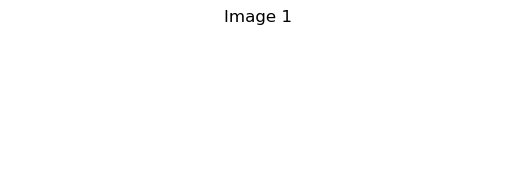

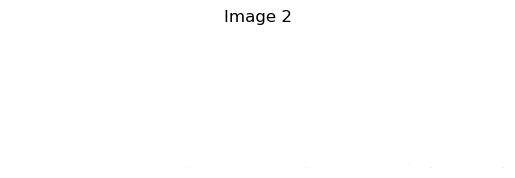

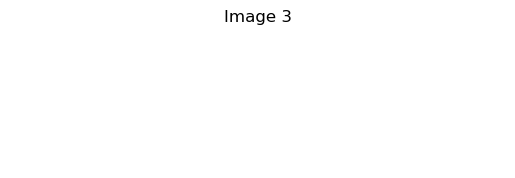

In [8]:
# Directory where the images are saved
image_directory = "/kaggle/working/flood-images"

# Get a list of all image files in the directory
image_files = os.listdir(image_directory)

# Display the first 3 images
for i in range(3):
    # Load the image as a grayscale image
    image_path = os.path.join(image_directory, image_files[i])
    image = plt.imread(image_path)

    # Display the image
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    plt.title(f"Image {i+1}")
    plt.show()

In [9]:
filtered_flood = filtered_flood.sort_values(by=['datetime', 'lon', 'lat'])

# Display the resulting filtered dataframe
display(filtered_flood.head(10))

,lon,lat,datetime,flood
11229,-72.625,-10.125,1998-01-01,1
11368,-57.875,-20.875,1998-01-01,1
11150,26.875,-0.875,1998-01-01,1
11430,28.625,40.875,1998-01-01,1
11162,36.625,-2.375,1998-01-01,1
11587,44.125,2.375,1998-01-01,1
11106,145.875,-18.625,1998-01-01,1
11230,-72.625,-10.125,1998-01-02,1
11369,-57.875,-20.875,1998-01-02,1
11151,26.875,-0.875,1998-01-02,1


In [10]:
filtered_flood.shape

(40247, 4)

In [11]:
# Create the output directory
output_directory = "/kaggle/working/flood-images"

# Create a ZIP file of the output directory
shutil.make_archive("/kaggle/working/flood-images", 'zip', output_directory)

'/kaggle/working/flood-images.zip'